# GWP 3 Python Script for downlading and analyzing the data

Group members are-


*   Christopher Enny Ofikwu, Nigeria, c.ofikwu@outlook.com
*   Bharat Swami, India, bharatswami1299@gmail.com
*   Chengjie Wang, China, cjay-wang@hotmail.com







### Required libraries

In [2]:
!pip install fredapi

In [46]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 3.7 MB/s eta 0:00:00


In [151]:
!pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 39.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12

In [262]:
import warnings
warnings.filterwarnings('ignore')

In [263]:
from fredapi import Fred
import pandas as pd
import os
import requests

from hmmlearn.hmm import GaussianHMM
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import HillClimbSearch, BIC, K2, BDeu
from pgmpy.estimators import BayesianEstimator
from hmmlearn.hmm import MultinomialHMM
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import networkx as nx
from pgmpy.inference import VariableElimination
from sklearn.preprocessing import KBinsDiscretizer

### Fred Data

In [264]:
API_KEY = "6e901c33818ae55a8172e0e4a238c567"
fred = Fred(api_key=API_KEY)

In [265]:

# Define FRED series codes and descriptions
fred_series = {
    'CPIAUCNS': 'Consumer Price Index (CPI)',
    'INDPRO': 'Industrial Production Index',
    'FEDFUNDS': 'Effective Federal Funds Rate',
    'UNRATE': 'Unemployment Rate',
    'GDPC1': 'Real GDP (Quarterly)',
    'M2SL': 'M2 Money Supply',
}

# Create a folder to store data
os.makedirs("fred_data", exist_ok=True)

#Download and save each series as a CSV
for code, name in fred_series.items():
    print(f"Downloading: {name} ({code})...")
    data = fred.get_series(code)
    df = data.to_frame(name=code)
    df.index.name = 'date'
    df.to_csv(f'fred_data/{code}.csv')
    print(f"Saved to fred_data/{code}.csv")

print("All FRED data downloaded.")



Downloading: Consumer Price Index (CPI) (CPIAUCNS)...
Saved to fred_data/CPIAUCNS.csv
Downloading: Industrial Production Index (INDPRO)...
Saved to fred_data/INDPRO.csv
Downloading: Effective Federal Funds Rate (FEDFUNDS)...
Saved to fred_data/FEDFUNDS.csv
Downloading: Unemployment Rate (UNRATE)...
Saved to fred_data/UNRATE.csv
Downloading: Real GDP (Quarterly) (GDPC1)...
Saved to fred_data/GDPC1.csv
Downloading: M2 Money Supply (M2SL)...
Saved to fred_data/M2SL.csv
All FRED data downloaded.


### EIA data

In [266]:
# Set your API Key here
EIA_API_KEY = 'qkoyhD48x2xU043k0sbGbQORKdvK2FmUcKnlF8m7'

In [267]:

# Create a directory to store data
os.makedirs("eia_data", exist_ok=True)

In [268]:
# Define series IDs and names
eia_series = {
    "PET.RWTC.D": "WTI_Spot_Price",
    "PET.RBRTE.D": "Brent_Spot_Price",
    "PET.WCESTUS1.W": "US_Crude_Oil_Stocks",
}


In [269]:

BASE_URL = 'https://api.eia.gov/v2/'

# Define datasets to fetch
datasets = [
    {
        'name': 'WTI_Spot_Price',
        'endpoint': 'petroleum/pri/spt',
        'params': {
            'frequency': 'monthly',
            'data': ['value'],
            'facets': {
                'product': ['EPCWTI']
            },
            'sort': [{'column': 'period', 'direction': 'desc'}],
            'offset': 0,
            'length': 5000
        }
    },
    {
        'name': 'Brent_Spot_Price',
        'endpoint': 'petroleum/pri/spt',
        'params': {
            'frequency': 'monthly',
            'data': ['value'],
            'facets': {
                'product': ['EPCBRENT']
            },
            'sort': [{'column': 'period', 'direction': 'desc'}],
            'offset': 0,
            'length': 5000
        }
    },
    # {
    #     'name': 'US_Crude_Oil_Stocks',
    #     'endpoint': 'petroleum/stoc/wstk',
    #     'params': {
    #         'frequency': 'monthly',
    #         'data': ['value'],
    #         'facets': {
    #             'area': ['US'],
    #             'product': ['EPC0']
    #         },
    #         'sort': [{'column': 'period', 'direction': 'desc'}],
    #         'offset': 0,
    #         'length': 5000
    #     }
    # },
    {
    'name': 'US_Crude_Oil_Stocks',
    'endpoint': 'petroleum/stoc/wstk',
    'params': {
    "frequency": "weekly",
    "data": [
        "value"
    ],
    "facets": {
        "process": [
            "SAE"
        ]
    },
    "start": None,
    "end": None,
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}
    },
    {
        'name': 'US_Crude_Oil_Production',
        'endpoint': 'petroleum/crd/crpdn',
        'params': {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {},
    "start": None,
    "end": None,
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}
    },




    {
        'name': 'US_Crude_Oil_Export',
        'endpoint': 'petroleum/move/exp',
          'params': {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {
        "process": [
            "EEX"
        ],
        "product": [
            "EPC0"
        ],
        "duoarea": [
            "NUS-Z00"
        ]
    },
    "start": None,
    "end": None,
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}
    },
    {
        'name': 'US_Crude_Oil_Import_by_counrty_of_origin',
        'endpoint': 'petroleum/move/impcus',
        'params': {
    "frequency": "monthly",
    "data": [
        "value"
    ],
    "facets": {
        "product": [
            "EPC0"
        ]
    },
    "start": None,
    "end": None,
    "sort": [
        {
            "column": "period",
            "direction": "desc"
        }
    ],
    "offset": 0,
    "length": 5000
}
    }

]

# Create directory to save data
os.makedirs('eia_data', exist_ok=True)

# Function to fetch and save data
def fetch_and_save(dataset):
    url = f"{BASE_URL}{dataset['endpoint']}/data/?api_key={EIA_API_KEY}"
    headers = {'Content-Type': 'application/json'}
    response = requests.post(url, headers=headers, json=dataset['params'])
    print(response)
    if response.status_code == 200:
        data = response.json()['response']['data']
        df = pd.DataFrame(data)
        df.to_csv(f"eia_data/{dataset['name']}.csv", index=False)
        print(f"Saved {dataset['name']} to eia_data/{dataset['name']}.csv")
    else:
        print(f"Failed to fetch {dataset['name']}: {response.status_code}")

# Fetch all datasets
for dataset in datasets:
    fetch_and_save(dataset)


<Response [200]>
Saved WTI_Spot_Price to eia_data/WTI_Spot_Price.csv
<Response [200]>
Saved Brent_Spot_Price to eia_data/Brent_Spot_Price.csv
<Response [200]>
Saved US_Crude_Oil_Stocks to eia_data/US_Crude_Oil_Stocks.csv
<Response [200]>
Saved US_Crude_Oil_Production to eia_data/US_Crude_Oil_Production.csv
<Response [200]>
Saved US_Crude_Oil_Export to eia_data/US_Crude_Oil_Export.csv
<Response [200]>
Saved US_Crude_Oil_Import_by_counrty_of_origin to eia_data/US_Crude_Oil_Import_by_counrty_of_origin.csv


### Combined data and data preprocessing

In [270]:
# Load FRED data
fred_path = "fred_data/"
fred_series = ['CPIAUCNS', 'INDPRO', 'FEDFUNDS', 'UNRATE', 'GDPC1', 'M2SL']
fred_data = {}

for code in fred_series:
    df = pd.read_csv(f"{fred_path}/{code}.csv", parse_dates=['date'], index_col='date')
    fred_data[code] = df.rename(columns={code: code})

# Merge all FRED into one DataFrame
df_fred = pd.concat(fred_data.values(), axis=1)


In [271]:
eia_path = "eia_data/"
eia_series = [
    'WTI_Spot_Price',
    'Brent_Spot_Price',
    'US_Crude_Oil_Stocks',
    'US_Crude_Oil_Production',
    'US_Crude_Oil_Export',
    'US_Crude_Oil_Import_by_counrty_of_origin'
]

eia_data = {}

for file in eia_series:
    df = pd.read_csv(f"{eia_path}/{file}.csv", parse_dates=['period'])

    # Group by date and aggregate to handle duplicates
    df = df.groupby('period')['value'].mean().to_frame(name=file)

    # Set datetime index
    df.index.name = 'date'
    eia_data[file] = df

# Now safely concatenate
df_eia = pd.concat(eia_data.values(), axis=1)


In [272]:
df_fred = df_fred.resample('M').ffill()
df_eia = df_eia.resample('M').ffill()

df_all = df_fred.join(df_eia, how='inner')


In [273]:
# Check for missing values
missing_summary = df_all.isna().sum()
print("Missing values per column:\n", missing_summary)

# Fill missing values (forward fill or interpolation)
df_all = df_all.fillna(method='ffill').fillna(method='bfill')


Missing values per column:
 CPIAUCNS                                       0
INDPRO                                         0
FEDFUNDS                                     414
UNRATE                                       336
GDPC1                                        951
M2SL                                         469
WTI_Spot_Price                               800
Brent_Spot_Price                             816
US_Crude_Oil_Stocks                         1256
US_Crude_Oil_Production                     1209
US_Crude_Oil_Export                            8
US_Crude_Oil_Import_by_counrty_of_origin    1173
dtype: int64


In [274]:
df_all.to_csv("preprocessed_data.csv")
print("Preprocessed data saved to preprocessed_data.csv")


Preprocessed data saved to preprocessed_data.csv


### Modeling

In [275]:
df = pd.read_csv("preprocessed_data.csv", parse_dates=['date'], index_col='date')

# Use Brent Spot Price as observed variable
# series = 'Brent_Spot_Price'
# use data from 2000
df = df[df.index >= '2000-01-01']
series = 'WTI_Spot_Price'
X = df[[series]].dropna().values
dates = df[[series]].dropna().index

In [276]:
df.head()

CPIAUCNS   INDPRO  FEDFUNDS  UNRATE      GDPC1    M2SL  \
date                                                                 
2000-01-31     168.8  91.4092      5.45     4.0  13878.147  4667.6   
2000-02-29     169.8  91.7245      5.73     4.1  13878.147  4680.9   
2000-03-31     171.2  92.0830      5.85     4.0  13878.147  4711.7   
2000-04-30     171.3  92.6659      6.02     3.8  14130.908  4767.8   
2000-05-31     171.5  92.9347      6.27     4.0  14130.908  4755.7   

            WTI_Spot_Price  Brent_Spot_Price  US_Crude_Oil_Stocks  \
date                                                                
2000-01-31           27.26             25.51         36000.931034   
2000-02-29           29.37             27.78         36000.931034   
2000-03-31           29.84             27.49         36000.931034   
2000-04-30           25.72             22.76         36000.931034   
2000-05-31           28.79             27.74         36000.931034   

            US_Crude_Oil_Production  US_Crude_Oil_Export  \
date                                                       
2000-01-31                   9417.8               2813.0   
2000-02-29                   9417.8                450.5   
2000-03-31                   9417.8               2296.5   
2000-04-30                   9417.8               1915.0   
2000-05-31                   9417.8                548.0   

            US_Crude_Oil_Import_by_counrty_of_origin  
date                                                  
2000-01-31                                  18428.95  
2000-02-29                                  18428.95  
2000-03-31                                  18428.95  
2000-04-30                                  18428.95  
2000-05-31                                  18428.95

In [277]:
# Initialize and train the HMM
model = GaussianHMM(n_components=2, covariance_type="diag", n_iter=5000, random_state=42)
model.fit(X)

# Predict hidden regimes
hidden_states = model.predict(X)

# Store results in DataFrame
df['market_regime'] = np.nan
df.loc[dates, 'market_regime'] = hidden_states

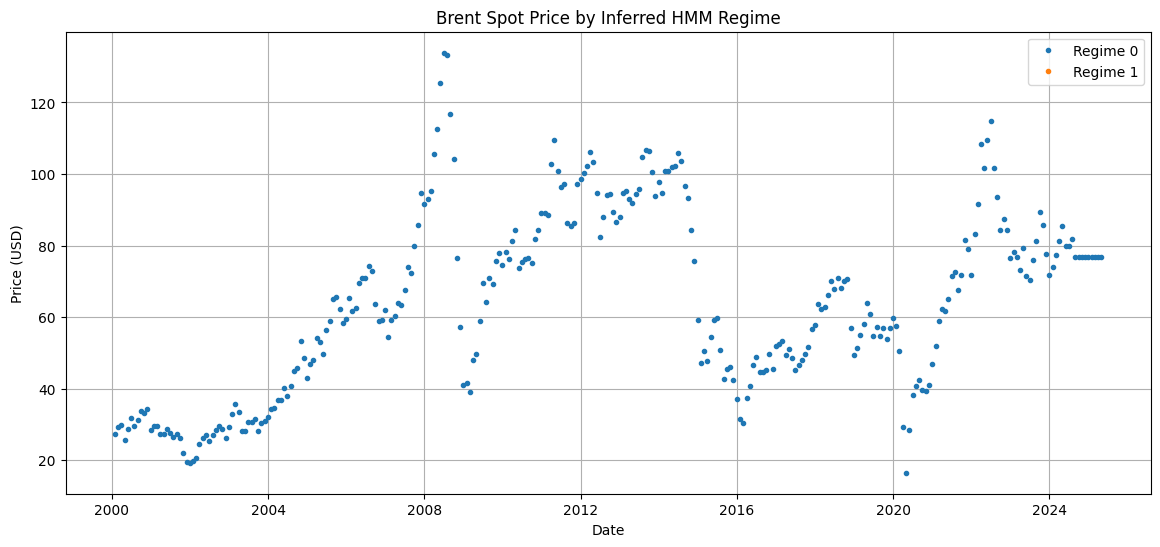

In [278]:
plt.figure(figsize=(14, 6))
for i in range(model.n_components):
    mask = df['market_regime'] == i
    plt.plot(df.index[mask], df[series][mask], '.', label=f'Regime {i}')
plt.title('Brent Spot Price by Inferred HMM Regime')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [279]:
for i in range(model.n_components):
    print(f"Regime {i} mean: {model.means_[i][0]:.2f}")


Regime 0 mean: 63.31
Regime 1 mean: 70.02


In [280]:

# Load data
df = pd.read_csv("preprocessed_data.csv", parse_dates=['date'], index_col='date')
df = df[df.index >= '2000-01-01']
# Select WTI price
series = 'WTI_Spot_Price'
X_continuous = df[[series]].dropna()


# Discretize into 4 bins (quartiles)
X_discrete = pd.qcut(X_continuous[series], q=3, labels=False)
X_discrete = X_discrete.values.reshape(-1, 1)
dates = X_continuous.index


In [281]:
# Initialize and train MultinomialHMM (DHMM)
model = MultinomialHMM(n_components=3, n_iter=1000, random_state=42)
model.fit(X_discrete)

# Predict hidden states
hidden_states = model.predict(X_discrete)

# Save back to DataFrame
df['dhmm_regime'] = np.nan
df.loc[dates, 'dhmm_regime'] = hidden_states


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


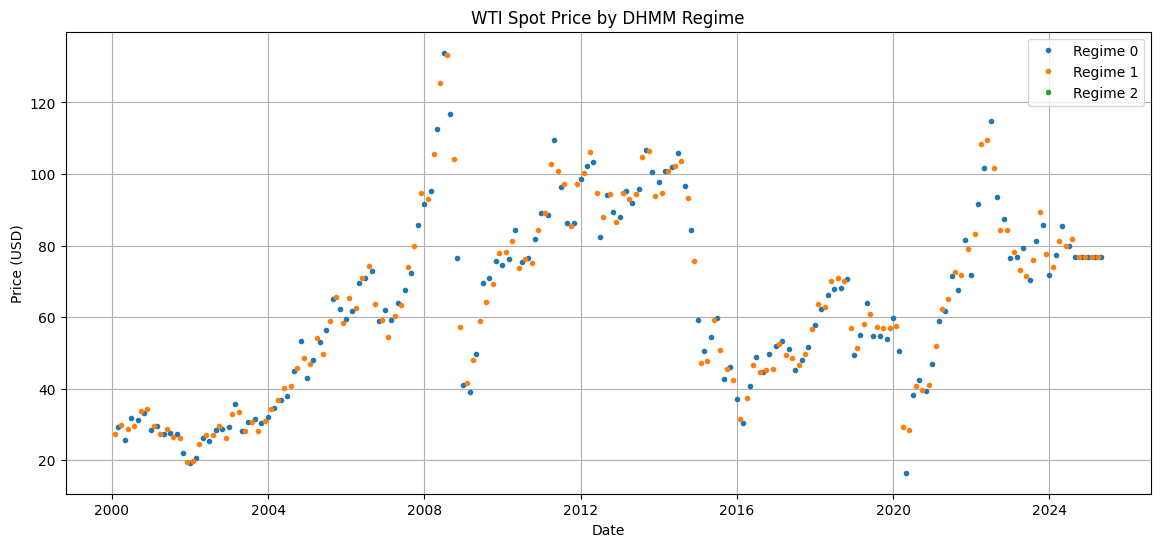

In [282]:
plt.figure(figsize=(14, 6))
for i in range(model.n_components):
    mask = df['dhmm_regime'] == i
    plt.plot(df.index[mask], df[series][mask], '.', label=f'Regime {i}')
plt.title('WTI Spot Price by DHMM Regime')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()


In [283]:
# Load preprocessed data
df = pd.read_csv("preprocessed_data.csv", parse_dates=['date'], index_col='date')
df = df[(df.index >= '1995-01-01') &( df.index <= '2015-01-01')]
price = df[['WTI_Spot_Price']].dropna()
dates = price.index

# Discretize into bins (add duplicates='drop')
X_discrete = pd.qcut(price['WTI_Spot_Price'], q=4, labels=False,duplicates='drop').values.reshape(-1, 1)

# Fit DHMM
model = MultinomialHMM(n_components=3, n_iter=1000, random_state=42)
model.fit(X_discrete)
s_seq = model.predict(X_discrete)


https://github.com/hmmlearn/hmmlearn/issues/335
https://github.com/hmmlearn/hmmlearn/issues/340


In [284]:
# Create price plot DataFrame
price_plot = price.copy()
price_plot['Regime'] = s_seq
price_plot['diff'] = price_plot['WTI_Spot_Price'].diff()

# Use average price change to assign regime labels
means = price_plot.groupby('Regime')['diff'].mean()
sorted_regimes = means.sort_values().index.tolist()  # lowest diff = bear, highest = bull
print(sorted_regimes)
map_regimes = {sorted_regimes[0]: 0,  # Bear
               sorted_regimes[1]: 1,  # Stagnant
              #  sorted_regimes[2]: 2
               }  # Bull

price_plot['Regime'] = price_plot['Regime'].map(map_regimes)


[0, 1]


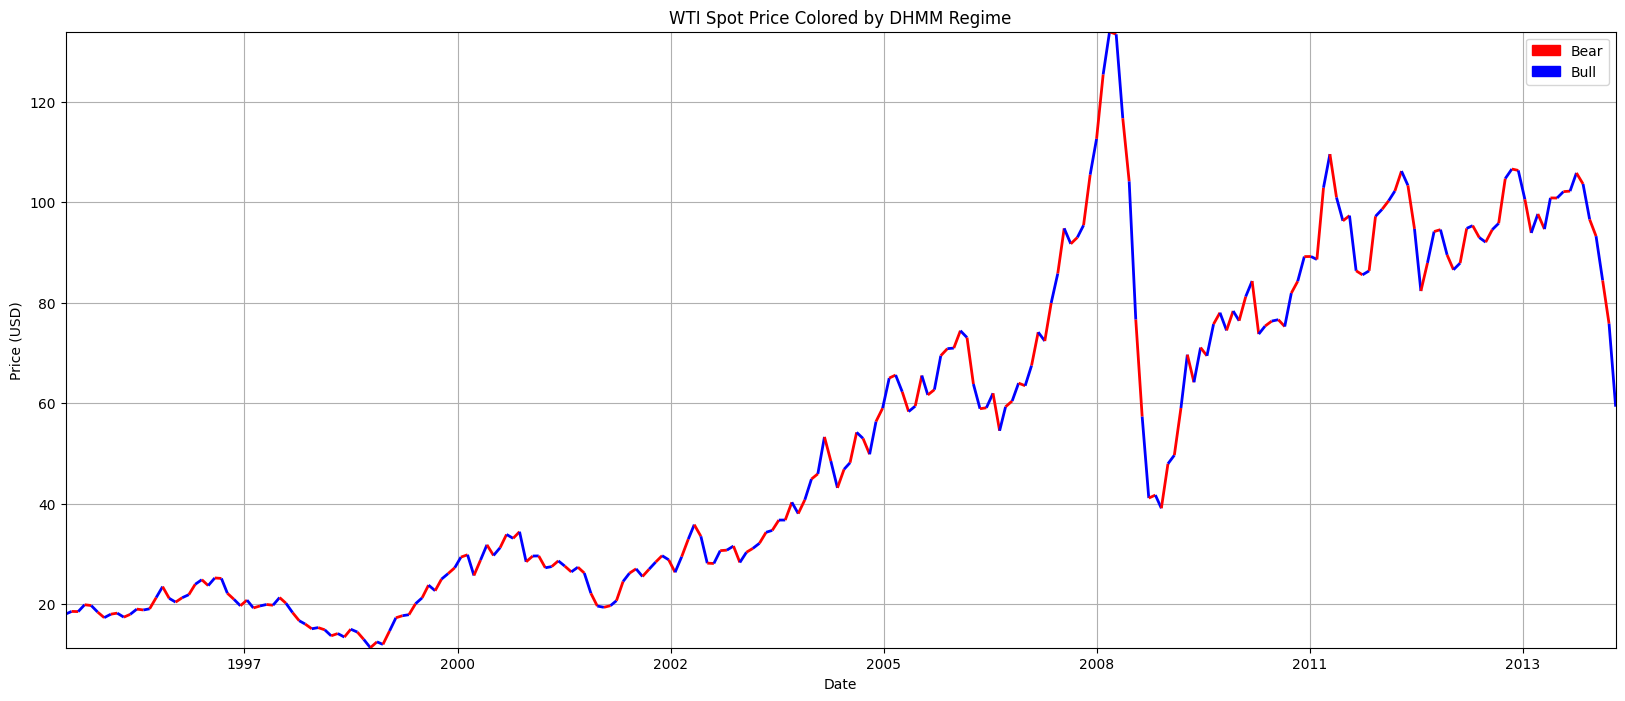

In [285]:


fig, ax = plt.subplots(figsize=(20, 8))

# Prepare data for multicolored segments
cmap = ListedColormap(['r', 'b', 'g'])  # Bear=Red, Stagnant=Blue, Bull=Green
norm = BoundaryNorm([0, 1, 2, 3], cmap.N)

# Convert datetime to matplotlib float format
inxval = mdates.date2num(price_plot.index.to_pydatetime())
price_vals = price_plot['WTI_Spot_Price'].values
segments = np.array([inxval, price_vals]).T.reshape(-1, 1, 2)
segments = np.concatenate([segments[:-1], segments[1:]], axis=1)

# Create line segments colored by regime
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(price_plot['Regime'].values[:-1])
lc.set_linewidth(2)
ax.add_collection(lc)

# Configure plot
ax.set_xlim(inxval.min(), inxval.max())
ax.set_ylim(price_vals.min(), price_vals.max())
ax.set_title("WTI Spot Price Colored by DHMM Regime")
ax.set_xlabel("Date")
ax.set_ylabel("Price (USD)")
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)

# Legend
legend_patches = [
    mpatches.Patch(color='red', label='Bear'),
    mpatches.Patch(color='blue', label='Bull'),
    # mpatches.Patch(color='green', label='Bull')
]
plt.legend(handles=legend_patches)
plt.show()


In [286]:

# Load preprocessed data
df = pd.read_csv("preprocessed_data.csv", parse_dates=['date'], index_col='date')

# Drop NaNs just to be safe
df = df.dropna()

# Select columns for discretization
cols = df.columns.tolist()
discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_discrete = pd.DataFrame(discretizer.fit_transform(df), columns=cols, index=df.index)
df_discrete = df_discrete.astype(int)


In [287]:
train_size = int(0.8 * len(df_discrete))
val_size = int(0.1 * len(df_discrete))

df_train = df_discrete.iloc[:train_size]
df_val = df_discrete.iloc[train_size:train_size+val_size]
df_test = df_discrete.iloc[train_size+val_size:]


In [288]:


hc = HillClimbSearch(df_train)
model_k2 = hc.estimate(scoring_method=K2(df_train))  # or K2Score, BDeuScore
model_bic = hc.estimate(scoring_method=BIC(df_train))  # or K2Score, BDeuScore
model_bdeu = hc.estimate(scoring_method=BDeu(df_train))  # or K2Score, BDeuScore



  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

### K2 model

In [289]:
bn_k2 = DiscreteBayesianNetwork(model_k2.edges())
bn_k2.fit(df_train, estimator=BayesianEstimator)
print("Nodes:", model_k2.nodes())
print("Edges:", model_k2.edges())

Nodes: ['CPIAUCNS', 'INDPRO', 'FEDFUNDS', 'UNRATE', 'GDPC1', 'M2SL', 'WTI_Spot_Price', 'Brent_Spot_Price', 'US_Crude_Oil_Stocks', 'US_Crude_Oil_Production', 'US_Crude_Oil_Export', 'US_Crude_Oil_Import_by_counrty_of_origin']
Edges: [('CPIAUCNS', 'INDPRO'), ('CPIAUCNS', 'FEDFUNDS'), ('CPIAUCNS', 'UNRATE'), ('CPIAUCNS', 'US_Crude_Oil_Export'), ('INDPRO', 'US_Crude_Oil_Export'), ('INDPRO', 'UNRATE'), ('INDPRO', 'FEDFUNDS'), ('FEDFUNDS', 'US_Crude_Oil_Export'), ('FEDFUNDS', 'UNRATE'), ('UNRATE', 'US_Crude_Oil_Export'), ('GDPC1', 'M2SL'), ('GDPC1', 'US_Crude_Oil_Export'), ('GDPC1', 'UNRATE'), ('GDPC1', 'INDPRO'), ('GDPC1', 'FEDFUNDS'), ('GDPC1', 'CPIAUCNS'), ('M2SL', 'CPIAUCNS'), ('M2SL', 'Brent_Spot_Price'), ('M2SL', 'WTI_Spot_Price'), ('M2SL', 'US_Crude_Oil_Export'), ('M2SL', 'UNRATE'), ('M2SL', 'INDPRO'), ('M2SL', 'FEDFUNDS'), ('WTI_Spot_Price', 'US_Crude_Oil_Export'), ('WTI_Spot_Price', 'UNRATE'), ('WTI_Spot_Price', 'INDPRO'), ('WTI_Spot_Price', 'FEDFUNDS'), ('WTI_Spot_Price', 'CPIAUCNS'

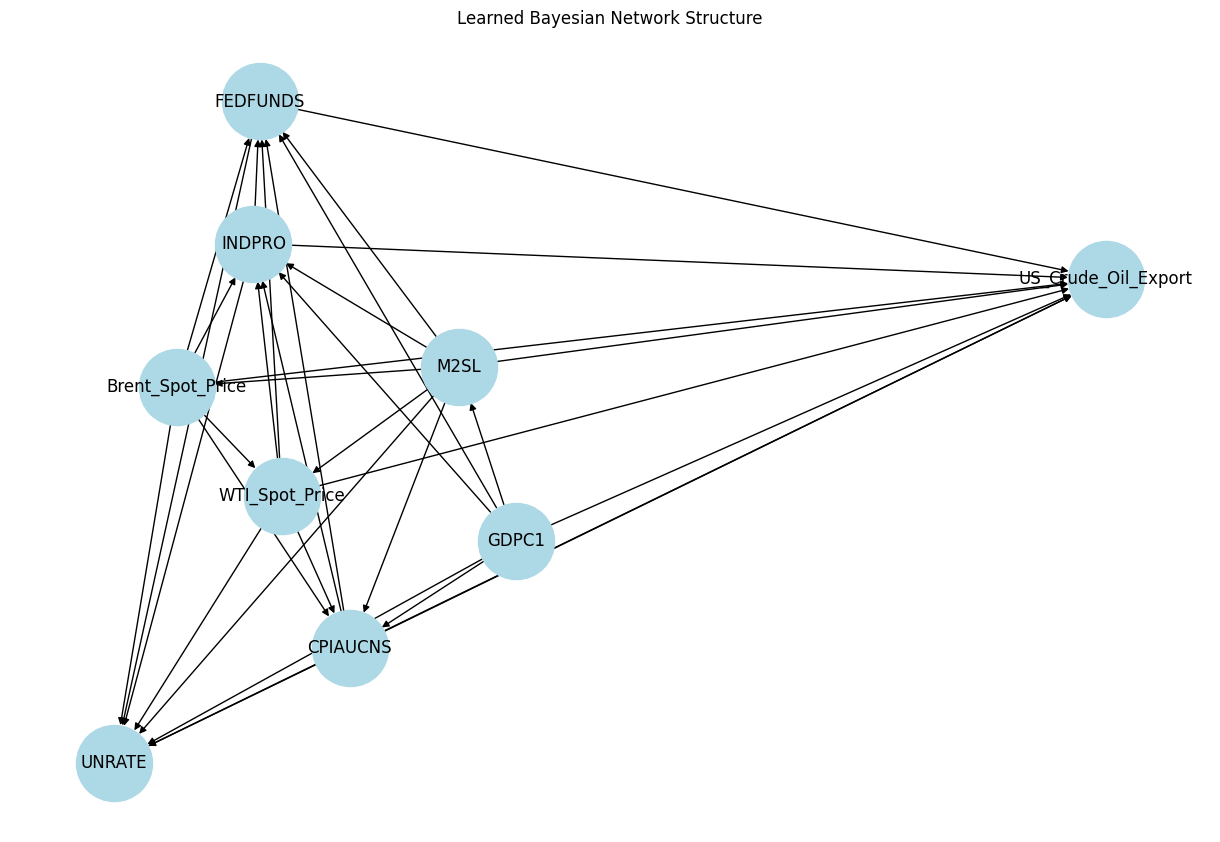

In [290]:

# Create a networkx DiGraph from model's edges
G_k2 = nx.DiGraph()
G_k2.add_edges_from(model_k2.edges())

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G_k2, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, arrows=True)
plt.title("Learned Bayesian Network Structure")
plt.show()

### BIC model

In [291]:
bn_bic = DiscreteBayesianNetwork(model_bic.edges())
bn_bic.fit(df_train, estimator=BayesianEstimator)
print("Nodes:", model_bic.nodes())
print("Edges:", model_bic.edges())

Nodes: ['CPIAUCNS', 'INDPRO', 'FEDFUNDS', 'UNRATE', 'GDPC1', 'M2SL', 'WTI_Spot_Price', 'Brent_Spot_Price', 'US_Crude_Oil_Stocks', 'US_Crude_Oil_Production', 'US_Crude_Oil_Export', 'US_Crude_Oil_Import_by_counrty_of_origin']
Edges: [('CPIAUCNS', 'M2SL'), ('CPIAUCNS', 'FEDFUNDS'), ('CPIAUCNS', 'UNRATE'), ('CPIAUCNS', 'US_Crude_Oil_Export'), ('INDPRO', 'CPIAUCNS'), ('M2SL', 'GDPC1'), ('M2SL', 'Brent_Spot_Price'), ('M2SL', 'WTI_Spot_Price'), ('WTI_Spot_Price', 'US_Crude_Oil_Export'), ('Brent_Spot_Price', 'WTI_Spot_Price'), ('US_Crude_Oil_Export', 'FEDFUNDS')]


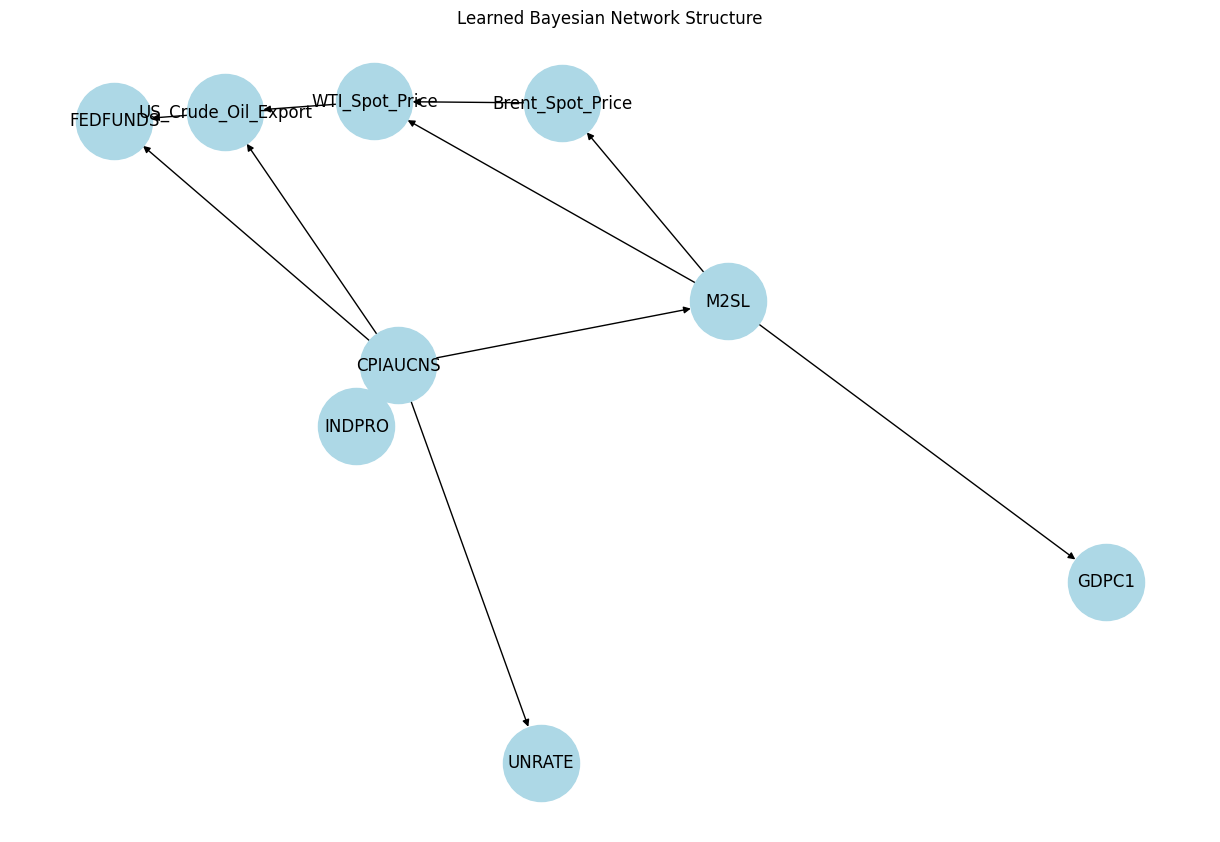

In [292]:

# Create a networkx DiGraph from model's edges
G_bic = nx.DiGraph()
G_bic.add_edges_from(model_bic.edges())

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G_bic, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, arrows=True)
plt.title("Learned Bayesian Network Structure")
plt.show()

### BDeu model

In [293]:
bn_bdeu = DiscreteBayesianNetwork(model_bdeu.edges())
bn_bdeu.fit(df_train, estimator=BayesianEstimator)
print("Nodes:", model_bdeu.nodes())
print("Edges:", model_bdeu.edges())

Nodes: ['CPIAUCNS', 'INDPRO', 'FEDFUNDS', 'UNRATE', 'GDPC1', 'M2SL', 'WTI_Spot_Price', 'Brent_Spot_Price', 'US_Crude_Oil_Stocks', 'US_Crude_Oil_Production', 'US_Crude_Oil_Export', 'US_Crude_Oil_Import_by_counrty_of_origin']
Edges: [('CPIAUCNS', 'M2SL'), ('CPIAUCNS', 'GDPC1'), ('CPIAUCNS', 'FEDFUNDS'), ('CPIAUCNS', 'UNRATE'), ('CPIAUCNS', 'US_Crude_Oil_Export'), ('CPIAUCNS', 'WTI_Spot_Price'), ('INDPRO', 'CPIAUCNS'), ('INDPRO', 'GDPC1'), ('INDPRO', 'Brent_Spot_Price'), ('INDPRO', 'M2SL'), ('INDPRO', 'US_Crude_Oil_Export'), ('FEDFUNDS', 'UNRATE'), ('GDPC1', 'M2SL'), ('M2SL', 'Brent_Spot_Price'), ('M2SL', 'WTI_Spot_Price'), ('WTI_Spot_Price', 'US_Crude_Oil_Export'), ('WTI_Spot_Price', 'FEDFUNDS'), ('Brent_Spot_Price', 'WTI_Spot_Price'), ('Brent_Spot_Price', 'UNRATE'), ('US_Crude_Oil_Export', 'FEDFUNDS')]


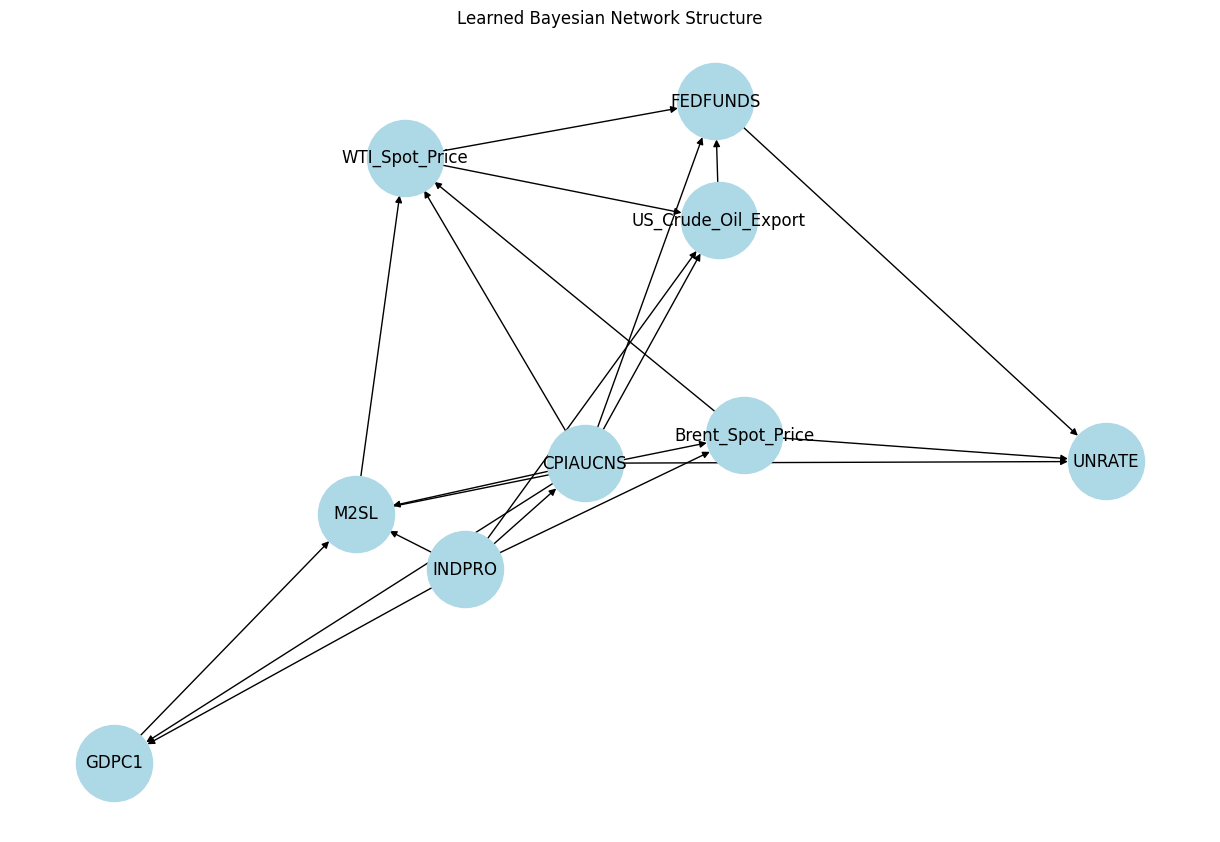

In [294]:

# Create a networkx DiGraph from model's edges
G_bdeu = nx.DiGraph()
G_bdeu.add_edges_from(model_bdeu.edges())

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G_bdeu, with_labels=True, node_size=3000, node_color='lightblue', font_size=12, arrows=True)
plt.title("Learned Bayesian Network Structure")
plt.show()

### backtesing and stress testing

In [296]:
# Build from structure
model = DiscreteBayesianNetwork(model_bdeu.edges())

# Fit parameters using training data
model.fit(df_train, estimator=BayesianEstimator)


In [297]:
infer = VariableElimination(model)

In [298]:
evidence = {
    'CPIAUCNS': 3,
    'GDPC1': 0,
    'M2SL': 2
}

query = infer.map_query(variables=['WTI_Spot_Price'], evidence=evidence)
print("Forecasted WTI Price State:", query['WTI_Spot_Price'])


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Forecasted WTI Price State: 0


In [299]:
for node in model.nodes():
    print(f"Variable: {node}")
    cpd = model.get_cpds(node)
    print("States:", cpd.state_names[node])


Variable: CPIAUCNS
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: M2SL
States: [np.int64(0), np.int64(1), np.int64(2)]
Variable: GDPC1
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: FEDFUNDS
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: UNRATE
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: US_Crude_Oil_Export
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: WTI_Spot_Price
States: [np.int64(0), np.int64(1)]
Variable: INDPRO
States: [np.int64(0), np.int64(1), np.int64(2), np.int64(3)]
Variable: Brent_Spot_Price
States: [np.int64(0), np.int64(1), np.int64(2)]


In [300]:

infer = VariableElimination(model)
model_nodes = set(model.nodes())

def map_to_state(var_name, value):
    cpd = model.get_cpds(var_name)
    allowed_states = cpd.state_names[var_name]

    # If value is already in allowed states, return it directly
    if value in allowed_states:
        return value

    # If states are integers and value is numeric, try to convert/clamp
    try:
        val_int = int(value)
        if val_int in allowed_states:
            return val_int
    except Exception:
        pass

    # Fallback: map to closest or first allowed state (here, first)
    print(f"Warning: Evidence for {var_name}={value} not in allowed states {allowed_states}. Using fallback {allowed_states[0]}.")
    return allowed_states[0]

predicted_states = []

for idx, row in df_val.iterrows():
    # Construct evidence dict without target variable
    evidence = row.drop('WTI_Spot_Price').to_dict()
    # Filter and map evidence values
    filtered_evidence = {
        k: map_to_state(k, v) for k, v in evidence.items() if k in model_nodes
    }

    # Run MAP query
    query = infer.map_query(variables=['WTI_Spot_Price'], evidence=filtered_evidence)
    predicted_states.append(query['WTI_Spot_Price'])

# print("Predicted states on validation set:", predicted_states)


0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:01, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [301]:
for col in evidence.keys():
    noise = np.random.choice([-1, 0, 1], size=len(df_val))  # small discrete noise
    df_val[col] = df_val[col] + noise
    df_val[col] = df_val[col].clip(lower=0)  # keep states valid


In [302]:
# model =  BayesianModel instance here

model_nodes = set(model.nodes())
input_features = model_nodes - {'WTI_Spot_Price'}

# Filter the test dataset columns to only the features the model expects (excluding target)
test_data_filtered = df_test.loc[:, list(input_features.intersection(df_test.columns))]

# Predict states with Bayesian model
test_prediction = model.predict(test_data_filtered)

# Extract predicted states for the target variable
pred_value_test = test_prediction['WTI_Spot_Price'].values

# Real states from test data (target variable)
test_real = df_test['WTI_Spot_Price'].values

# Calculate prediction error (shift prediction for forecasting one step ahead)
error = (test_real != np.roll(pred_value_test, 1)).mean()

print("\nPredicted Values:")
print(pred_value_test)

print("\nReal Values:")
print(test_real)

print(f"\nForecasting Error (%): {error * 100:.2f}")



  0%|          | 0/7 [00:00<?, ?it/s]


Predicted Values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]

Real Values:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

Forecasting Error (%): 26.77


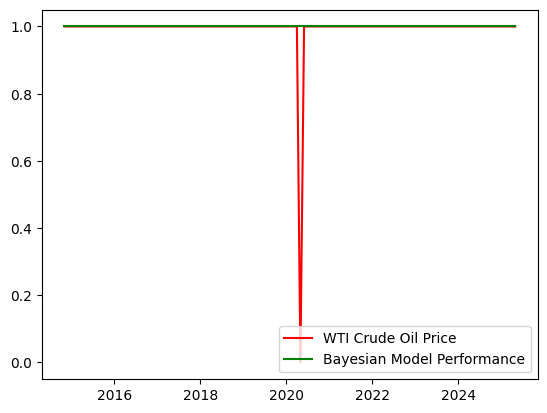

In [303]:

test_price = df_test[['WTI_Spot_Price']]
test_signal = pd.DataFrame(test_prediction, columns=['WTI_Spot_Price_signal'])
test_sheet = pd.concat([test_price, test_signal], axis=1, join='inner')

trades = [test_sheet['WTI_Spot_Price'].iloc[0]]
position = False  # False = Short, True = Long

for i in range(len(test_sheet) - 1):
    signal = test_sheet['WTI_Spot_Price'].iloc[i + 1]
    if signal == 0:
        trades.append(trades[-1])
    elif signal == 2:
        if not position:
            position = True
        trades.append(test_sheet['WTI_Spot_Price'].iloc[i + 1])
    else:  # signal == 1
        if not position:
            trades.append(trades[-1])
        else:
            trades.append(test_sheet['WTI_Spot_Price'].iloc[i + 1])

test_performance = pd.DataFrame(trades, index=test_sheet.index, columns=['performance'])
test_sheet = pd.concat([test_sheet, test_performance], axis=1, join='inner')

# Plotting
plt.plot(test_sheet['WTI_Spot_Price'], 'r', label='WTI Crude Oil Price')
plt.plot(test_sheet['performance'], 'g', label='Bayesian Model Performance')

plt.legend(loc='lower right')
plt.show()

In [304]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2014-10-31 to 2025-04-30
Data columns (total 12 columns):
 #   Column                                    Non-Null Count  Dtype
---  ------                                    --------------  -----
 0   CPIAUCNS                                  127 non-null    int64
 1   INDPRO                                    127 non-null    int64
 2   FEDFUNDS                                  127 non-null    int64
 3   UNRATE                                    127 non-null    int64
 4   GDPC1                                     127 non-null    int64
 5   M2SL                                      127 non-null    int64
 6   WTI_Spot_Price                            127 non-null    int64
 7   Brent_Spot_Price                          127 non-null    int64
 8   US_Crude_Oil_Stocks                       127 non-null    int64
 9   US_Crude_Oil_Production                   127 non-null    int64
 10  US_Crude_Oil_Export                       1